In [1]:
### Plotting bettis

script_start_time = time()
println("\nimporting packages...")

using Pkg
using Statistics
using LinearAlgebra
using Eirene
using StatsBase
using JLD
using Plots
Pkg.add("ColorSchemes")
using ColorSchemes
using JSON

include("helper_functions.jl")
println("packages and functions imported")
printstyled("Elapsed time = $(time() - script_start_time) seconds \n \n", color = :yellow)

HTML{String}("<script>\n// Immediately-invoked-function-expression to avoid global variables.\n(function() {\n    var warning_div = document.getElementById(\"webio-warning-5379127387163760329\");\n    var hide = function () {\n        var script = document.getElementById(\"webio-setup-5236223687485175605\");\n        var parent = script && script.parentElement;\n        var grandparent = parent && parent.parentElement;\n        if (grandparent) {\n            grandparent.style.display = \"none\";\n        }\n        warning_div.style.display = \"none\";\n    };\n    if (typeof Jupyter !== \"undefined\") {\n        console.log(\"WebIO detected Jupyter notebook environment.\");\n        // Jupyter notebook.\n        var extensions = (\n            Jupyter\n            && Jupyter.notebook.config.data\n            && Jupyter.notebook.config.data.load_extensions\n        );\n        if (extensions && extensions[\"webio-jupyter-notebook\"]) {\n            // Extension already loaded.\n            console.log(\"Jupyter WebIO nbextension detected; not loading ad-hoc.\");\n            hide();\n            return;\n        }\n    } else if (window.location.pathname.includes(\"/lab\")) {\n        // Guessing JupyterLa\n        console.log(\"Jupyter Lab detected; make sure the @webio/jupyter-lab-provider labextension is installed.\");\n        hide();\n        return;\n    }\n})();\n\n</script>\n<p\n    id=\"webio-warning-5379127387163760329\"\n    class=\"output_text output_stderr\"\n    style=\"padding: 1em; font-weight: bold;\"\n>\n    Unable to load WebIO. Please make sure WebIO works for your Jupyter client.\n    For troubleshooting, please see <a href=\"https://juliagizmos.github.io/WebIO.jl/latest/providers/ijulia/\">\n    the WebIO/IJulia documentation</a>.\n    <!-- TODO: link to installation docs. -->\n</p>\n")


importing packages...


┌ Info: Recompiling stale cache file /opt/julia/compiled/v1.2/Plots/ld3vC.ji for Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1240


  Updating registry at `/opt/julia/registries/General`
 Resolving package versions...


┌ Warning: Some registries failed to update:
│     — `/opt/julia/registries/General` — registry dirty
└ @ Pkg.Types /buildworker/worker/package_linux64/build/usr/share/julia/stdlib/v1.2/Pkg/src/Types.jl:1171


  Updating `/opt/julia/environments/v1.2/Project.toml`
  [35d6a980] + ColorSchemes v3.9.0
  Updating `/opt/julia/environments/v1.2/Manifest.toml`
 [no changes]
packages and functions imported
Elapsed time = 74.50192904472351 seconds 
 


In [2]:
### Set parameters

# Read from config file
config_file = "config092420.json"
config = read_config("$(homedir())/configs/$(config_file)")

# Parameters for all graphs
const NNODES = config["NNODES"]
const MAXDIM = config["MAXDIM"]
const NREPS = config["NREPS"]
const DATE_STRING = config["DATE_STRING"]


### Locate data and find nametags
read_dir = "../processed_data/results/$(NNODES)nodes"
betti_files = filter(x->occursin("_bettis",x), readdir(read_dir))
betti_files = filter(x->occursin(DATE_STRING, x), betti_files)
betti_files = filter(x->!occursin("dsi", x), betti_files)
println("Located the following graph files:")
# for betti_file in betti_files
#     println(betti_file)
# end


# Locate the nametags
nametags = []
for betti_file in betti_files
    println(betti_file)
    tag = split(split(betti_file, "$(DATE_STRING)_")[2], "_bettis")[1]
    nametags = [nametags; tag]
end

nametags = unique(nametags)


for nametag in nametags
    namefiles = filter(x->occursin(nametag,x), betti_files)
    if length(namefiles)<12
    println(nametag)
    println(length(namefiles))
    end
end

nametags

Located the following graph files:
IID_70nodes_200reps_092420_overlap_a01_b03_overlap_bettis.jld
IID_70nodes_200reps_092420_overlap_a02_b04_overlap_bettis.jld
IID_70nodes_200reps_092420_overlap_a03_b05_overlap_bettis.jld
IID_70nodes_200reps_092420_overlap_a04_b06_overlap_bettis.jld
IID_70nodes_200reps_092420_overlap_a05_b07_overlap_bettis.jld
IID_70nodes_200reps_092420_overlap_a06_b08_overlap_bettis.jld
IID_70nodes_200reps_092420_overlap_a07_b09_overlap_bettis.jld
IID_70nodes_200reps_092420_thresh015_edge363_noiseOnly_bettis.jld
IID_70nodes_200reps_092420_thresh015_edge363_randomized_threshold_bettis.jld
IID_70nodes_200reps_092420_thresh015_edge363_threshold_bettis.jld
IID_70nodes_200reps_092420_thresh01_edge242_noiseOnly_bettis.jld
IID_70nodes_200reps_092420_thresh01_edge242_randomized_threshold_bettis.jld
IID_70nodes_200reps_092420_thresh01_edge242_threshold_bettis.jld
IID_70nodes_200reps_092420_thresh025_edge604_noiseOnly_bettis.jld
IID_70nodes_200reps_092420_thresh025_edge604_rando

coreperiphery_70nodes_200reps_15_5_10_5_092420_thresh025_edge604_threshold_bettis.jld
coreperiphery_70nodes_200reps_15_5_10_5_092420_thresh02_edge483_noiseOnly_bettis.jld
coreperiphery_70nodes_200reps_15_5_10_5_092420_thresh02_edge483_randomized_threshold_bettis.jld
coreperiphery_70nodes_200reps_15_5_10_5_092420_thresh02_edge483_threshold_bettis.jld
coreperiphery_70nodes_200reps_15_5_10_5_092420_thresh035_edge846_noiseOnly_bettis.jld
coreperiphery_70nodes_200reps_15_5_10_5_092420_thresh035_edge846_randomized_threshold_bettis.jld
coreperiphery_70nodes_200reps_15_5_10_5_092420_thresh035_edge846_threshold_bettis.jld
coreperiphery_70nodes_200reps_15_5_10_5_092420_thresh03_edge725_noiseOnly_bettis.jld
coreperiphery_70nodes_200reps_15_5_10_5_092420_thresh03_edge725_randomized_threshold_bettis.jld
coreperiphery_70nodes_200reps_15_5_10_5_092420_thresh03_edge725_threshold_bettis.jld
coreperiphery_70nodes_200reps_15_5_10_5_092420_thresh045_edge1087_noiseOnly_bettis.jld
coreperiphery_70nodes_200r

disassortative_70nodes_200reps_20_5_10_5_092420_thresh035_edge846_noiseOnly_bettis.jld
disassortative_70nodes_200reps_20_5_10_5_092420_thresh035_edge846_randomized_threshold_bettis.jld
disassortative_70nodes_200reps_20_5_10_5_092420_thresh035_edge846_threshold_bettis.jld
disassortative_70nodes_200reps_20_5_10_5_092420_thresh03_edge725_noiseOnly_bettis.jld
disassortative_70nodes_200reps_20_5_10_5_092420_thresh03_edge725_randomized_threshold_bettis.jld
disassortative_70nodes_200reps_20_5_10_5_092420_thresh03_edge725_threshold_bettis.jld
disassortative_70nodes_200reps_20_5_10_5_092420_thresh045_edge1087_noiseOnly_bettis.jld
disassortative_70nodes_200reps_20_5_10_5_092420_thresh045_edge1087_randomized_threshold_bettis.jld
disassortative_70nodes_200reps_20_5_10_5_092420_thresh045_edge1087_threshold_bettis.jld
disassortative_70nodes_200reps_20_5_10_5_092420_thresh04_edge966_noiseOnly_bettis.jld
disassortative_70nodes_200reps_20_5_10_5_092420_thresh04_edge966_randomized_threshold_bettis.jld
d

dotProduct_70nodes_200reps_3_092420_thresh035_edge846_noiseOnly_bettis.jld
dotProduct_70nodes_200reps_3_092420_thresh035_edge846_randomized_threshold_bettis.jld
dotProduct_70nodes_200reps_3_092420_thresh035_edge846_threshold_bettis.jld
dotProduct_70nodes_200reps_3_092420_thresh03_edge725_noiseOnly_bettis.jld
dotProduct_70nodes_200reps_3_092420_thresh03_edge725_randomized_threshold_bettis.jld
dotProduct_70nodes_200reps_3_092420_thresh03_edge725_threshold_bettis.jld
dotProduct_70nodes_200reps_3_092420_thresh045_edge1087_noiseOnly_bettis.jld
dotProduct_70nodes_200reps_3_092420_thresh045_edge1087_randomized_threshold_bettis.jld
dotProduct_70nodes_200reps_3_092420_thresh045_edge1087_threshold_bettis.jld
dotProduct_70nodes_200reps_3_092420_thresh04_edge966_noiseOnly_bettis.jld
dotProduct_70nodes_200reps_3_092420_thresh04_edge966_randomized_threshold_bettis.jld
dotProduct_70nodes_200reps_3_092420_thresh04_edge966_threshold_bettis.jld
dotProduct_70nodes_200reps_3_092420_thresh055_edge1329_nois

randomGeom_70nodes_200reps_3_092420_thresh04_edge966_noiseOnly_bettis.jld
randomGeom_70nodes_200reps_3_092420_thresh04_edge966_randomized_threshold_bettis.jld
randomGeom_70nodes_200reps_3_092420_thresh04_edge966_threshold_bettis.jld
randomGeom_70nodes_200reps_3_092420_thresh055_edge1329_noiseOnly_bettis.jld
randomGeom_70nodes_200reps_3_092420_thresh055_edge1329_randomized_threshold_bettis.jld
randomGeom_70nodes_200reps_3_092420_thresh055_edge1329_threshold_bettis.jld
randomGeom_70nodes_200reps_3_092420_thresh05_edge1208_noiseOnly_bettis.jld
randomGeom_70nodes_200reps_3_092420_thresh05_edge1208_randomized_threshold_bettis.jld
randomGeom_70nodes_200reps_3_092420_thresh05_edge1208_threshold_bettis.jld
randomGeom_70nodes_200reps_3_092420_thresh065_edge1570_noiseOnly_bettis.jld
randomGeom_70nodes_200reps_3_092420_thresh065_edge1570_randomized_threshold_bettis.jld
randomGeom_70nodes_200reps_3_092420_thresh065_edge1570_threshold_bettis.jld
randomGeom_70nodes_200reps_3_092420_thresh06_edge1449

rmsd_70nodes_200reps_3_092420_thresh07_edge1691_threshold_bettis.jld
rmsd_70nodes_200reps_3_092420_thresh085_edge2053_noiseOnly_bettis.jld
rmsd_70nodes_200reps_3_092420_thresh085_edge2053_randomized_threshold_bettis.jld
rmsd_70nodes_200reps_3_092420_thresh085_edge2053_threshold_bettis.jld
rmsd_70nodes_200reps_3_092420_thresh08_edge1932_noiseOnly_bettis.jld
rmsd_70nodes_200reps_3_092420_thresh08_edge1932_randomized_threshold_bettis.jld
rmsd_70nodes_200reps_3_092420_thresh08_edge1932_threshold_bettis.jld
rmsd_70nodes_200reps_3_092420_thresh09_edge2174_noiseOnly_bettis.jld
rmsd_70nodes_200reps_3_092420_thresh09_edge2174_randomized_threshold_bettis.jld
rmsd_70nodes_200reps_3_092420_thresh09_edge2174_threshold_bettis.jld
sqdEuclidean_70nodes_200reps_3_092420_overlap_a01_b03_overlap_bettis.jld
sqdEuclidean_70nodes_200reps_3_092420_overlap_a02_b04_overlap_bettis.jld
sqdEuclidean_70nodes_200reps_3_092420_overlap_a03_b05_overlap_bettis.jld
sqdEuclidean_70nodes_200reps_3_092420_overlap_a04_b06_o

58-element Array{Any,1}:
 "overlap_a01_b03_overlap"                
 "overlap_a02_b04_overlap"                
 "overlap_a03_b05_overlap"                
 "overlap_a04_b06_overlap"                
 "overlap_a05_b07_overlap"                
 "overlap_a06_b08_overlap"                
 "overlap_a07_b09_overlap"                
 "thresh015_edge363_noiseOnly"            
 "thresh015_edge363_randomized_threshold" 
 "thresh015_edge363_threshold"            
 "thresh01_edge242_noiseOnly"             
 "thresh01_edge242_randomized_threshold"  
 "thresh01_edge242_threshold"             
 ⋮                                        
 "thresh07_edge1691_noiseOnly"            
 "thresh07_edge1691_randomized_threshold" 
 "thresh07_edge1691_threshold"            
 "thresh085_edge2053_noiseOnly"           
 "thresh085_edge2053_randomized_threshold"
 "thresh085_edge2053_threshold"           
 "thresh08_edge1932_noiseOnly"            
 "thresh08_edge1932_randomized_threshold" 
 "thresh08_edge1932_threshold

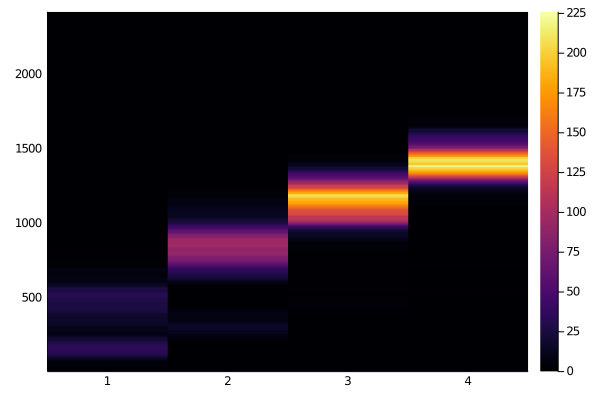

In [42]:
graph_dict = load("../processed_data/overlap_graphs/70nodes/assortative_70nodes_200reps_20_5_10_5_092420_graphs_overlap_a02_b04.jld")
MAXDIM =3
rep = 3
nEdges = binomial(70,2)
weighted_graph_array = graph_dict["weighted_graph_array_overlap"]

heatmap(weighted_graph_array[:,:,150])

betti_dict = load("../processed_data/results/70nodes/assortative_70nodes_200reps_20_5_10_5_092420_overlap_a01_b03_overlap_bettis.jld")
bettis = betti_dict["bettisArray"]

heatmap(bettis[30,:,:])

# bdic = load("../processed_data/results/70nodes/assortative_70nodes_200reps_20_5_10_5_092420_overlap_a02_b04_eireneoutput_overlap.jld")
# ba = bdic["barcodeArray"]
# ba[150,:]




In [3]:

bettisAllAvg = []
for (j,nametag) in enumerate(nametags)
    
    ## Create one large plot with all of the betti curves
    betti_files_nametag = filter(x -> occursin("$(nametag)",x), betti_files)
    model_names = [split(betti_file_nametag,"_")[1] for betti_file_nametag in betti_files_nametag]
    
    nModels = length(betti_files_nametag)
    nEdges = binomial(NNODES, 2)
    bettisAll = zeros(NREPS, nEdges, MAXDIM, nModels)
    
#     println(length(betti_files_nametag))
    
    for (i,betti_file_nametag) in enumerate(betti_files_nametag)

        # Read in Betti curves
        betti_dict = load("$(read_dir)/$(betti_file_nametag)")
        if maximum(betti_dict["bettisArray"]) == 0
            print("no bettis")
        end
        bettisAll[:,:,:, i] = betti_dict["bettisArray"]
#         println(betti_file_nametag)

    end

    bettisAllAvg = dropdims(mean(bettisAll, dims=1), dims=1)
    bettisAllStd = dropdims(std(bettisAll, dims=1), dims=1)
    println("Size bettisAllAvg is $(size(bettisAllAvg))")

    # Finally plot
    p1a = plot(bettisAllAvg[:,1,:], 
        layout = 12, 
        size = (3000,2000), 
        title = ["$(model_names[i])" for j=1:1, i=1:nModels],
        ribbon = bettisAllStd[:,1,:])
    for d=2:MAXDIM
        plot!(bettisAllAvg[:,d,:],legend = nothing, xlabel = "Edges added", ylabel="Beta_k",
        xticks=[(i/5)*nEdges for i=0:5],
        ribbon = bettisAllStd[:,d,:])

    end
    
    # If the file is of threshold type, add the threshold line
    if occursin("threshold", nametag)
        
        # Get threshold edge
        thresh_string = split(split(nametag,"edge")[2],"_")[1]
        threshold_edge = parse(Int, thresh_string)
        println("processing threshold edge $(threshold_edge)")
        
        # Plot the vertical line
        vline!(transpose([threshold_edge for i=1:nModels]), color=:gray)
#         yaxis!([zeros(1,length(yaxis_lims)), yaxis_lims])
    end


    savefig("../figures/all_bettis_$(nametag)_$(DATE_STRING).pdf")
    
    
    
end






Size bettisAllAvg is (2415, 4, 12)
Size bettisAllAvg is (2415, 4, 12)
Size bettisAllAvg is (2415, 4, 12)
Size bettisAllAvg is (2415, 4, 12)
Size bettisAllAvg is (2415, 4, 12)
Size bettisAllAvg is (2415, 4, 12)
Size bettisAllAvg is (2415, 4, 12)
Size bettisAllAvg is (2415, 4, 12)
Size bettisAllAvg is (2415, 4, 12)
processing threshold edge 363
Size bettisAllAvg is (2415, 4, 12)
processing threshold edge 363
Size bettisAllAvg is (2415, 4, 12)
Size bettisAllAvg is (2415, 4, 12)
processing threshold edge 242
Size bettisAllAvg is (2415, 4, 12)
processing threshold edge 242
Size bettisAllAvg is (2415, 4, 12)
Size bettisAllAvg is (2415, 4, 12)
processing threshold edge 604
Size bettisAllAvg is (2415, 4, 12)
processing threshold edge 604
Size bettisAllAvg is (2415, 4, 12)
Size bettisAllAvg is (2415, 4, 12)
processing threshold edge 483
Size bettisAllAvg is (2415, 4, 12)
processing threshold edge 483
Size bettisAllAvg is (2415, 4, 12)
Size bettisAllAvg is (2415, 4, 12)
processing threshold edge

In [21]:
## Heatmaps -- B+


bettisAllAvg = []

for (j,nametag) in enumerate(nametags)
    
    ## Create one large plot with all of the betti curves
    betti_files_nametag = filter(x -> occursin("$(nametag)",x), betti_files)
    model_names = [split(betti_file_nametag,"_")[1] for betti_file_nametag in betti_files_nametag]
    
    nModels = length(betti_files_nametag)
    nEdges = binomial(NNODES, 2)
    bettisAll = zeros(NREPS, nEdges, MAXDIM, nModels)
    
#     println(length(betti_files_nametag))
    
    plot_array = Any[]
    
    for (i,betti_file_nametag) in enumerate(betti_files_nametag)

        # Read in Betti curves
        betti_dict = load("$(read_dir)/$(betti_file_nametag)")
        bettisAll[:,:,:, i] = betti_dict["bettisArray"]
#         println(betti_file_nametag)

    end

    bettisAllAvg = dropdims(mean(bettisAll, dims=1), dims=1)
    println("Size bettisAllAvg is $(size(bettisAllAvg))")

    # Finally plot
    for i = 1:size(bettisAllAvg)[3]
        p1b = heatmap(transpose(bettisAllAvg[:,:,i]), size=(900,300), cb=:top)
        push!(plot_array,p1b)
    end
    

    plot(plot_array...)
    savefig("../figures/all_bettis_$(nametag)_$(DATE_STRING)_heatmap.pdf")
    
    
    
end






Size bettisAllAvg is (2415, 4, 12)
Size bettisAllAvg is (2415, 4, 12)
Size bettisAllAvg is (2415, 4, 12)
Size bettisAllAvg is (2415, 4, 12)
Size bettisAllAvg is (2415, 4, 12)
Size bettisAllAvg is (2415, 4, 11)
Size bettisAllAvg is (2415, 4, 12)
Size bettisAllAvg is (2415, 4, 11)
Size bettisAllAvg is (2415, 4, 12)
Size bettisAllAvg is (2415, 4, 12)
Size bettisAllAvg is (2415, 4, 12)
Size bettisAllAvg is (2415, 4, 12)
Size bettisAllAvg is (2415, 4, 12)
Size bettisAllAvg is (2415, 4, 12)
Size bettisAllAvg is (2415, 4, 12)
Size bettisAllAvg is (2415, 4, 12)
Size bettisAllAvg is (2415, 4, 12)
Size bettisAllAvg is (2415, 4, 12)
Size bettisAllAvg is (2415, 4, 12)
Size bettisAllAvg is (2415, 4, 12)
Size bettisAllAvg is (2415, 4, 12)
Size bettisAllAvg is (2415, 4, 12)
Size bettisAllAvg is (2415, 4, 12)
Size bettisAllAvg is (2415, 4, 12)
Size bettisAllAvg is (2415, 4, 12)
Size bettisAllAvg is (2415, 4, 12)
Size bettisAllAvg is (2415, 4, 12)
Size bettisAllAvg is (2415, 4, 12)
Size bettisAllAvg is

In [47]:
##### Make special figures for thresholded stuff

# Maybe just betti bar first

# Filter to just the thresholds
thresh_files = filter(x->occursin("thresh",x), betti_files)
thresh_files = filter(x->!occursin("noiseOnly",x), thresh_files)
thresh_files = filter(x -> !occursin("randomized",x), thresh_files)


# Locate the thresh nametages
thresh_nametags = []
for thresh_file in thresh_files
    tag = split(split(thresh_file, "$(DATE_STRING)_")[2], "_bettis")[1]
    thresh_nametags = [thresh_nametags; tag]
end

thresh_nametags = unique(thresh_nametags)

## And locate the model names
model_names = []
for thresh_file in thresh_files
    name = split(thresh_file, "_thresh")[1]
    model_names = [model_names; name]
end

model_names = unique(model_names)
model_names_short = [split(model_name,"_")[1] for model_name in model_names]


12-element Array{SubString{String},1}:
 "IID"                
 "assortative"        
 "coreperiphery"      
 "cosineGeometric"    
 "disassortative"     
 "discreteUniformConf"
 "dotProduct"         
 "geometricConf"      
 "randomGeom"         
 "ringLattice"        
 "rmsd"               
 "sqdEuclidean"       

In [53]:
nEdges = binomial(NNODES, 2)
plot_array3 = Any[]


for (j,model_name) in enumerate(model_names)
# model_name = "randomGeom_70nodes_200reps_3_092420"
    bettis = []

    model = split(model_name, "_")[1]
    # Loop through threshold vals and create vector of means and begin plotting

    betti_peaks_all = zeros(NREPS, MAXDIM, length(thresh_nametags))

    p3 = plot()

    rho_vec = []
    max_val_k =[]
    mean_bettis = []
    max_locs = Array{Float64}(undef, (0,MAXDIM))
    max_vals = Array{Float64}(undef, (0,MAXDIM))

    
    for (i,thresh_nametag) in enumerate(thresh_nametags)
        
        # Load data
        bettis_dict = load("$(read_dir)/$(model_name)_$(thresh_nametag)_bettis.jld")
        bettis = bettis_dict["bettisArray"]
        
    
        rho = split(split(thresh_nametag, "thresh")[2], "_")[1]
        rho = replace(rho, "0" => "0.")
        rho = parse(Float64, rho)
        
        rho_vec = [rho_vec; rho]
        
        mean_bettis = dropdims(mean(bettis, dims=1), dims=1)
    
        # Find max and location of max peak
        max_val_k = dropdims(maximum(mean_bettis, dims=1), dims=1)
        max_vals = [max_vals; transpose(max_val_k)]
    
        # Find locations of max value
        max_loc = zeros(1,4)
        for dim in collect(1:MAXDIM)
            max_loc[1, dim] = findfirst(mean_bettis[:, dim].==max_val_k[dim])
        end
        max_locs = [max_locs; max_loc]
            
        

    
        plot!([1:nEdges],mean_bettis, c=[[:blue] [:green] [:red] [:pink]], alpha = (rho+0.1), legend =false, lw=4)
#         xlabel!("Edges")
        ylabel!("Betti_k")
    
        scatter!(max_loc, transpose(max_val_k),lw=0, m=:dot, markeralpha = (rho+0.1), alpha = (rho+0.1), 
        markerstrokecolor=:match, markerstrokewidth=0, c=[[:blue] [:green] [:red] [:pink]],
        xticks=[(i/5)*nEdges for i=0:5])
        title!("$(model)")
        
#         scatter!(max_locs, max_vals, lw=0, m=:dot, c = RGBA(1,0,0, 0.5))

        
        
        
    end

plot(p3)

    push!(plot_array3,p3)


    
    
    
end

plot(plot_array3..., size = (3000,2000))
savefig("../figures/all_bcurves_$(DATE_STRING).pdf")


(1, 4)
(2, 4)
(3, 4)
(4, 4)
(5, 4)
(6, 4)
(7, 4)
(8, 4)
(9, 4)
(10, 4)
(11, 4)
(12, 4)
(13, 4)
(14, 4)
(15, 4)
(16, 4)
(17, 4)
(1, 4)
(2, 4)
(3, 4)
(4, 4)
(5, 4)
(6, 4)
(7, 4)
(8, 4)
(9, 4)
(10, 4)
(11, 4)
(12, 4)
(13, 4)
(14, 4)
(15, 4)
(16, 4)
(17, 4)
(1, 4)
(2, 4)
(3, 4)
(4, 4)
(5, 4)
(6, 4)
(7, 4)
(8, 4)
(9, 4)
(10, 4)
(11, 4)
(12, 4)
(13, 4)
(14, 4)
(15, 4)
(16, 4)
(17, 4)
(1, 4)
(2, 4)
(3, 4)
(4, 4)
(5, 4)
(6, 4)
(7, 4)
(8, 4)
(9, 4)
(10, 4)
(11, 4)
(12, 4)
(13, 4)
(14, 4)
(15, 4)
(16, 4)
(17, 4)
(1, 4)
(2, 4)
(3, 4)
(4, 4)
(5, 4)
(6, 4)
(7, 4)
(8, 4)
(9, 4)
(10, 4)
(11, 4)
(12, 4)
(13, 4)
(14, 4)
(15, 4)
(16, 4)
(17, 4)
(1, 4)
(2, 4)
(3, 4)
(4, 4)
(5, 4)
(6, 4)
(7, 4)
(8, 4)
(9, 4)
(10, 4)
(11, 4)
(12, 4)
(13, 4)
(14, 4)
(15, 4)
(16, 4)
(17, 4)
(1, 4)
(2, 4)
(3, 4)
(4, 4)
(5, 4)
(6, 4)
(7, 4)
(8, 4)
(9, 4)
(10, 4)
(11, 4)
(12, 4)
(13, 4)
(14, 4)
(15, 4)
(16, 4)
(17, 4)
(1, 4)
(2, 4)
(3, 4)
(4, 4)
(5, 4)
(6, 4)
(7, 4)
(8, 4)
(9, 4)
(10, 4)
(11, 4)
(12, 4)
(13, 4)
(14, 4)
(15, 4)


In [5]:
### Max vals and locations curves

nEdges = binomial(NNODES, 2)
plot_array3 = Any[]
plot_array4 = Any[]

for (j,model_name) in enumerate(model_names)
# model_name = "assortative_70nodes_50reps_15_5_10_5_091520"
    bettis = []

    model = split(model_name, "_")[1]
    # Loop through threshold vals and create vector of means and begin plotting

    betti_peaks_all = zeros(NREPS, MAXDIM, length(thresh_nametags))

    p3 = plot()

    rho_vec = []
    max_val_k =[]
    mean_bettis = []
    max_locs = Array{Float64}(undef, (0,MAXDIM))
    max_vals = Array{Float64}(undef, (0,MAXDIM))

    
    for (i,thresh_nametag) in enumerate(thresh_nametags)
        
        # Load data
        bettis_dict = load("$(read_dir)/$(model_name)_$(thresh_nametag)_bettis.jld")
        bettis = bettis_dict["bettisArray"]
        
    
        rho = split(split(thresh_nametag, "thresh")[2], "_")[1]
        rho = replace(rho, "0" => "0.")
        rho = parse(Float64, rho)
        
        rho_vec = [rho_vec; rho]
        
        mean_bettis = dropdims(mean(bettis, dims=1), dims=1)
    
        # Find max and location of max peak
        max_val_k = dropdims(maximum(mean_bettis, dims=1), dims=1)
        max_vals = [max_vals; transpose(max_val_k)]
    
        # Find locations of max value
        max_loc = zeros(1,4)
        for dim in collect(1:MAXDIM)
            max_loc[1, dim] = findfirst(mean_bettis[:, dim].==max_val_k[dim])
        end
        max_locs = [max_locs; max_loc]
            
        

    
        plot!([1:nEdges],mean_bettis, c=[[:blue] [:green] [:red] [:pink]], alpha = (rho+0.1), legend =false, lw=2)
#         xlabel!("Edges")
        ylabel!("Betti_k")


        
        
        
    end
    
    
    p4 = plot(size=(500,300))
    plot!(max_locs, max_vals, alpha = rho_vec, c=[[:blue] [:green] [:red] [:pink]],
        legend = false, m=:dot, lw=0, xlims=[0,nEdges])
    xlabel!("Peak Location")
    ylabel!("Peak Value")
    title!("$(model)")


        
#     plot(p3,p4,layout=(2, 1), size=(500,1000))
    push!(plot_array4,p4)
    push!(plot_array3,p3)


    
    
    
end

plot(plot_array4..., size = (3000,2000))
savefig("../figures/all_peakplots_$(DATE_STRING).pdf")


plot(plot_array3..., size = (1500,3000))
savefig("../figures/all_bettisthreshs_$(DATE_STRING).pdf")

In [ ]:
## Look at crossover and blue-only bettis



nEdges = binomial(NNODES, 2)
plot_array5 = Any[]


for (j,model_name) in enumerate(model_names)

    # Extract model name
    model = split(model_name, "_")[1]

    # Prepare for plotting
    p5 = plot(layout = (MAXDIM, 1))

    
    for (i,thresh_nametag) in enumerate(thresh_nametags)
        
        # Load data
        barcodeArray = load("$(read_dir)/$(model_name)_$(replace(thresh_nametag, "_threshold" => ""))_eireneoutput_threshold.jld","barcodeArray")
        
        # Read threshold edge
        thresh_string = split(split(thresh_nametag,"edge")[2],"_")[1]
        threshold_edge = parse(Int, thresh_string)
        
        rho = split(split(thresh_nametag, "thresh")[2], "_")[1]
        rho = replace(rho, "0" => "0.")
        rho = parse(Float64, rho)
        
        # Calculate betti curves
        nReps = size(barcodeArray)[1]
        maxdim = size(barcodeArray)[2]
        bettisArray_oranges = zeros(nReps,nEdges,maxdim)
        bettisArray_crossover = zeros(nReps,nEdges,maxdim)
        bettisArray_blues = zeros(nReps,nEdges,maxdim)
        for rep in 1:nReps
            for k in collect(1:maxdim)
        
                # Filter to orange bars
                barcode_oranges = deepcopy(barcodeArray[rep, k])
                barcode_oranges = barcode_oranges[(barcode_oranges[:,1] .<= threshold_edge) .& (barcode_oranges[:,2] .<= threshold_edge),:]

        
                # Calculate betti curves
                bettisArray_oranges[rep, :, k] = betticurveFromBarcode(barcode_oranges, nEdges)
                
                # Filter crossover bars
                barcode_crossover = deepcopy(barcodeArray[rep, k])
                barcode_crossover = barcode_crossover[(barcode_crossover[:,1] .<= threshold_edge) .& (barcode_crossover[:,2] .> threshold_edge),:]

                
                # Calculate crossover bars
                bettisArray_crossover[rep, :, k] = betticurveFromBarcode(barcode_crossover, nEdges)
                
                # Filter blue bars
                barcode_blues = deepcopy(barcodeArray[rep, k])
                barcode_blues = barcode_blues[(barcode_blues[:,1] .> threshold_edge) .& (barcode_blues[:,2] .> threshold_edge),:]


                # Calculate betti curves
                bettisArray_blues[rep, :, k] = betticurveFromBarcode(barcode_blues, nEdges)
            end
        end
        
        
        plot!([1:nEdges],dropdims(mean(bettisArray_oranges,dims=1),dims=1), c=[[:navy] [:teal] [:brown] [:purple]], alpha = (rho+0.1), legend =false, lw=2)
        ylabel!("Betti_k")
        plot!([1:nEdges],dropdims(mean(bettisArray_crossover,dims=1),dims=1), c=[[:blue] [:green] [:red] [:pink]], alpha = (rho+0.1), legend =false, lw=2)
        ylabel!("Betti_k")
        plot!([1:nEdges],dropdims(mean(bettisArray_blues,dims=1),dims=1), c=[[:cyan] [:yellow] [:orange] [:gray]], alpha = (rho+0.1), legend =false, lw=2)
        ylabel!("Betti_k")

        
    end
    
    
        

    push!(plot_array5,p5)



    
    
    
end


println("Constructing plot...")
plot(plot_array5..., size = (1500,3000))
savefig("../figures/all_tribettis_$(DATE_STRING).pdf")
println("Saved!")

# plot(plot_array3..., size = (1500,3000))
# savefig("../figures/all_bettisthreshs_$(DATE_STRING).pdf")

In [ ]:
## Look at crossover and blue-only bettis grouped by threshold

nEdges = binomial(NNODES, 2)
nModels = length(model_names)


for (i,thresh_nametag) in enumerate(thresh_nametags)
    
    # Create a big array to store bettis
    bettisAll_oranges = zeros(NREPS, nEdges, MAXDIM, nModels)
    bettisAll_crossover = zeros(NREPS, nEdges, MAXDIM, nModels)
    bettisAll_blues = zeros(NREPS, nEdges, MAXDIM, nModels)


    
    for (j,model_name) in enumerate(model_names)
        
        # Load data
        barcodeArray = load("$(read_dir)/$(model_name)_$(replace(thresh_nametag, "_threshold" => ""))_eireneoutput_threshold.jld","barcodeArray")
        
        
        # Read threshold edge
        thresh_string = split(split(thresh_nametag,"edge")[2],"_")[1]
        threshold_edge = parse(Int, thresh_string)
        
        rho = split(split(thresh_nametag, "thresh")[2], "_")[1]
        rho = replace(rho, "0" => "0.")
        rho = parse(Float64, rho)
        
        # Calculate betti curves
        nReps = size(barcodeArray)[1]
        maxdim = size(barcodeArray)[2]
        bettisArray_oranges = zeros(nReps,nEdges,maxdim)
        bettisArray_crossover = zeros(nReps,nEdges,maxdim)
        bettisArray_blues = zeros(nReps,nEdges,maxdim)
        for rep in 1:nReps
            for k in collect(1:maxdim)
        
                # Filter to orange bars
                barcode_oranges = deepcopy(barcodeArray[rep, k])
                barcode_oranges = barcode_oranges[(barcode_oranges[:,1] .<= threshold_edge) .& (barcode_oranges[:,2] .<= threshold_edge),:]

        
                # Calculate betti curves
                bettisAll_oranges[rep, :, k, j] = betticurveFromBarcode(barcode_oranges, nEdges)
                
                # Filter crossover bars
                barcode_crossover = deepcopy(barcodeArray[rep, k])
                barcode_crossover = barcode_crossover[(barcode_crossover[:,1] .<= threshold_edge) .& (barcode_crossover[:,2] .> threshold_edge),:]

                
                # Calculate crossover bars
                bettisAll_crossover[rep, :, k, j] = betticurveFromBarcode(barcode_crossover, nEdges)
                
                # Filter blue bars
                barcode_blues = deepcopy(barcodeArray[rep, k])
                barcode_blues = barcode_blues[(barcode_blues[:,1] .> threshold_edge) .& (barcode_blues[:,2] .> threshold_edge),:]


                # Calculate betti curves
                bettisAll_blues[rep, :, k, j] = betticurveFromBarcode(barcode_blues, nEdges)
            end
        end
        
        end  # end model
    
        
        
    # Finally plot
    bettisAllAvg_blues = dropdims(mean(bettisAll_blues, dims=1), dims=1)
    bettisAllAvg_crossover = dropdims(mean(bettisAll_crossover, dims=1), dims=1)
    bettisAllAvg_oranges = dropdims(mean(bettisAll_oranges, dims=1), dims=1)
        
        
    p6 = plot(bettisAllAvg_oranges[:,1,:], c=:orange,
        layout = 40, size = (2000,1600),
        title = ["$(model_names_short[i])" for j=1:1, i=1:nModels])
    
    for d=2:MAXDIM
        plot!(bettisAllAvg_oranges[:,d,:], c=:orange, alpha = 1-(d/(MAXDIM+2)),
            legend = nothing, xlabel = "Edges added", ylabel="Beta_k")

    end
    
    for d=1:MAXDIM
        plot!(bettisAllAvg_crossover[:,d,:], c=:green, alpha = 1-(d/(MAXDIM+2)),
            legend = nothing, xlabel = "Edges added", ylabel="Beta_k", lw=2)
    end
    
    for d=1:MAXDIM
        plot!(bettisAllAvg_blues[:,d,:], c=:blue, alpha = 1-(d/(MAXDIM+2)),
            legend = nothing, xlabel = "Edges added", ylabel="Beta_k")
    end

        

    println("Constructing plot...")
    savefig("../figures/all_tribettis_$(DATE_STRING)_$(thresh_nametag).pdf")
    println("Saved!")


    
    
    
end


cone check

In [ ]:
##### Make special figures for cone check stuff



# Filter to just the thresholds
cone_files = filter(x->occursin("eireneoutput",x), readdir(read_dir))
cone_files = filter(x->occursin("conelevel",x), cone_files)


## And locate the model names
model_names = []
for cone_file in cone_files
    name = split(cone_file, "_conelevel")[1]
    model_names = [model_names; name]
end

model_names = unique(model_names)

# identify cone_levels
cone_nametags


In [ ]:
nEdges = binomial(NNODES, 2)
plot_array = Any[]
# model_name = "coreperiphery_70nodes_100reps_15_5_10_5_091720"
for (j,model_name) in enumerate(model_names)

    # Load in ph_forward
    barcode_forward = load("$(read_dir)/$(model_name)_forward.jld", "barcodeArray")
    
    # Create counts of each 
    barcode_forward_counts = (length.(barcode_forward))./2
    
    
    # Find levels 
    # Locate the thresh nametages
    cone_nametags = []
    for cone_file in filter(x -> (occursin("conelevel",x) && occursin("$(model_name)",x)),cone_files)
        tag = split(split(cone_file, "eireneoutput_")[2], ".jld")[1]
        cone_nametags = [cone_nametags; tag]
    end

    cone_nametags = unique(cone_nametags)
    println(cone_nametags)

    
    

    model = split(model_name, "_")[1]

    mean_counts = zeros(4,length(cone_nametags)+1)
    mean_counts[:,1] = dropdims(mean(barcode_forward_counts, dims=1), dims=1)

    level_vec = [0]
    barcodei = []
    
    for (i,cone_nametag) in enumerate(sort(cone_nametags))
        
        # Load data
        barcodei = load("$(read_dir)/$(model_name)_$(cone_nametag).jld", "barcodeArray")
        
    
        level = split(cone_nametag, "level")[2]
        level = parse(Float64, level)
        
        level_vec = [level_vec; level]
        
        # Create counts of each 
        barcode_counts = (length.(barcodei))./2
        mean_counts[:,i+1] = dropdims(mean(barcode_counts, dims=1), dims=1)
    

        
        
        
    end

    pi = plot(sort(level_vec), transpose(mean_counts[:, sortperm(level_vec)]), m=:dot, lw=1)
    xlabel!("nodes removed")
    ylabel!("Barcode counts")
    title!("$(model)")
    
    push!(plot_array,pi)



    
    
    
end

plot(plot_array..., size = (3000,2000))
savefig("../figures/all_conecounts_$(DATE_STRING).pdf") 


# plot(plot_array3..., size = (1500,3000))
# savefig("../figures/all_bettisthreshs_$(DATE_STRING).pdf")

Bounding Betti k

$$ f_k = \binom{L}{k+1}+ p^{m_k}\binom{M}{k+1} + \sum_{i=0}^{k-1}p^{m_k - m_i}\binom{L}{i+1}\binom{M}{k-i}$$.

$$= \binom{L}{k+1}+ p^{m_k}\binom{M}{k+1} + p^{m_k}\binom{M}{k}L + \sum_{i=1}^{k-1}p^{m_k - m_i}\binom{L}{i+1}\binom{M}{k-i}$$.

In [ ]:
# Only need to compute f_k for k=1 - 5

m_k = [binomial(i+1,2) for i in 1:5]

L=5
M=10-L
p=0.5

function f_k(k,L,M,p)
    
    m_k = [binomial(i+1,2) for i in 1:(k)]
    term1 = binomial(L,k+1)
    println("term 1 $(term1)")
    
    term2 = (p^(m_k[k]))*binomial(M,k+1)
    println("term 2 $(term2)")
    
    term3 = (p^(m_k[k]))*binomial(M,k)*L
    println("term 3 $(term3)")
    
    term4_vec = [(p^(m_k[k] - m_k[i])) * binomial(L, i+1) * binomial(M, k-i) for i = 1:(k-1)]
    println(term4_vec)
    term4 = sum(term4_vec)
    
    return term1+term2+term3+term4
    
end

f_k(2,L,M,p)

In [ ]:
-f_k(1,L,M,p) + f_k(2,L,M,p) - f_k(3,L,M,p)

In [ ]:
L=35
M=70-L

pvec = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
f_1_vec = [f_k(1,L,M,p_i) for p_i in pvec]
f_2_vec = [f_k(2,L,M,p_i) for p_i in pvec]
f_3_vec = [f_k(3,L,M,p_i) for p_i in pvec]
f_4_vec = [f_k(4,L,M,p_i) for p_i in pvec]
pnew = plot(pvec,f_1_vec, m=:dot)
plot!(pvec,f_2_vec,m=:dot)
plot!(pvec,f_3_vec,m=:dot)
plot!(pvec,f_4_vec,m=:dot)
plot!(pvec,f_3_vec .- f_2_vec .- f_4_vec)

plot(pnew)

In [ ]:
dropdims(f_k_vec,dims=1)